# Binary classification with unbalanced classes: A case study



Throughout this notebook, I am going to study a dataset hosted by UCI Machine Learning repository. You can find this dataset at this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/00222/)

The dataset I will be using in this notebook is bank-additional-full.csv which contains 41188 rows and 20 attributes. The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required. Here, we would like to predict if the client would subscribe to bank term deposit. The target variabe is labeled "y" (yes/no).

There are 3 types of input features :
- Bank client data: personal information of clients (age, education, job, loans...)
- Features related to the current and previous campaigns: contact communication type, last contact day and month, #of contacts performed during this campaign, outcome of previous camapign, etc.
- Social and economic context attributes.

For a full description of these features, please visit this [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

The main libraries involved in this work are:
- **NumPy**: the fundamental package for scientific computing
- **Pandas**: a package with user-friendly data structures and data analysis tools
- **Matplotlib** and **seaborn** for data visualization
- **scikit-learn**: the machine learning package
- **imbalanced-learn**: a python package offering re-sampling techniques for datasets with class-imbalance

Let's get started!

## 1 - Exploratory  data analysis##
As in traditional Machine Lerning projects, let's start by gaining our first insights and intuitions by exploring the dataset.

This part is organized as follow:
- Data extraction: loading dataset from UCI Machine Learning repository and spliting it into 2 seperate datasets: train and test sets.
- Data visualization: making interesting charts and graphs to describe data distribution and identify correlations and hidden patterns.
- Assumptions: based on the charts and graphs, some assumptions will be formulated and used later on to preprocess data.

Now, let's begin by importing the packages:


In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category = DeprecationWarning)
import pandas as pd
import numpy as np
import os, io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import zipfile

Using requests and zipfile packages, a zip file from the UCI repository is downloaded and extracted to ./data directory. The dataset in "bank-additional-full.csv" is read as pandas dataframe. The next time this cell is ran, we directly load the dataset from the newly created directory


In [2]:
try:
    full_df = pd.read_csv(r'data/bank-additional/bank-additional-full.csv',sep=';')
except:
    url = r'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
    r = requests.get(url)
    r.headers.get('content-type')#check if it is a zip file
    zipfile = zipfile.ZipFile(io.BytesIO(r.content))
    zipfile.namelist()#read the content of zipfile
    zipfile.extractall(path = r'./data')#extract zip files to the specified directory (here ./data)
    full_df = pd.read_csv(zipfile.open('bank-additional/bank-additional-full.csv'),sep=';')
    
full_df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


The target variable is **y**, if y = yes, the client has subscribed a term deposit, otherwise no.
Let's convert this binary variable to 1/0 and display some information on features and data types:

In [3]:
full_df['y']= full_df['y'].map({'yes':1,'no':0}).astype(int)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null int32
dtypes: float64(5), int32(1), int64(5), object(10)
m

For testing purposes, we need to split our dataset into 2 separate datasets with the ratio 4:1, a trainng set to build predictive models and a test set to score and evaluate these models using a set of metrics

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(full_df, test_size = 0.2, random_state=0)
train_df.shape, test_df.shape

((32950, 21), (8238, 21))

Now let's describe numerical features:

In [5]:
train_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,39.966798,257.513748,2.562671,962.475053,0.171351,0.082464,93.576258,-40.506771,3.622056,5167.052589,0.112929
std,10.433052,259.084398,2.753415,186.912344,0.492456,1.572617,0.578960,4.627707,1.734723,72.359995,0.316510
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,318.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


Here are some findings:
- There is no missing values.
- For pdays variable, more than 75% of records have pdays = 999, which means that the majority of clients have never been contacted in previous campaigns.
- The dataset is skewed toward the negative classe : more than 75% of clients have not subscribed a term deposit.
More precisely:

In [6]:
train_df['y'].value_counts(normalize = True)

0    0.887071
1    0.112929
Name: y, dtype: float64

These marketing campaigns are only successful in 11.3% of cases.
This will influence the choice of the appropriate metrics to evaluate our predictive models.
Below a description of the categorical features:

In [7]:
train_df.describe(include = ['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,32950,32950,32950,32950,32950,32950,32950,32950,32950,32950
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,8370,19901,9770,26116,17266,27201,20937,10954,6901,28481


Here are some remarks:
- A lot of variables are unknown, which means they are missing.
- the poutcome input variable is valued nonexistent in +85% of the time. We may fairly assume that this value corresponds to a first-time campaign. This feature will be analysed later on to determine if this assumption is true.

Now let's make some charts: 

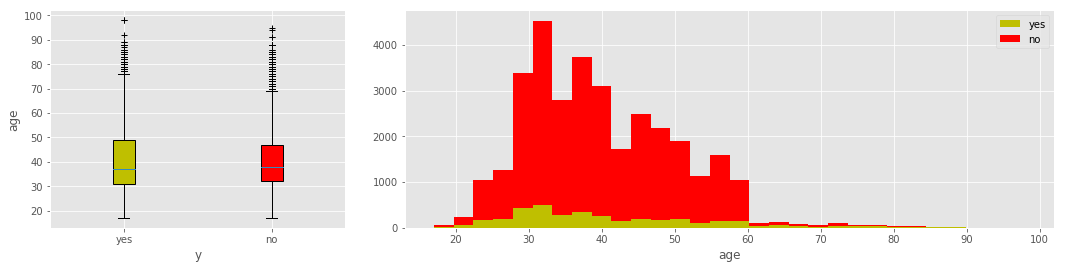

In [8]:
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')

age_y = [train_df[train_df['y']==1]['age'],train_df[train_df['y']==0]['age']]
fig = plt.figure(figsize=(18,4))
gs = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[:,1:])

#boxplot
bplot = ax1.boxplot(age_y, labels = ['yes','no'], sym = '+',vert = True, patch_artist = True)
colors = ['y','r']
for patch,color in zip(bplot['boxes'],colors):
    patch.set_facecolor(color)
ax1.set_xlabel('y')
ax1.set_ylabel('age')

#histogram
plt.hist(age_y, stacked = True, color = colors, bins = 30, label = ['yes','no'])
ax2.set_xlabel('age')
ax2.legend(loc="best")

plt.show()

We can see that the boxplot for the positive class is more stretched. Thus, senior people are more likely to subscribe.

In the histogram, you may notice that there is a sudden drop in the number of clients at the age of 60. It seems that the bank targets the active population.

Let's take a look at jobs distribution

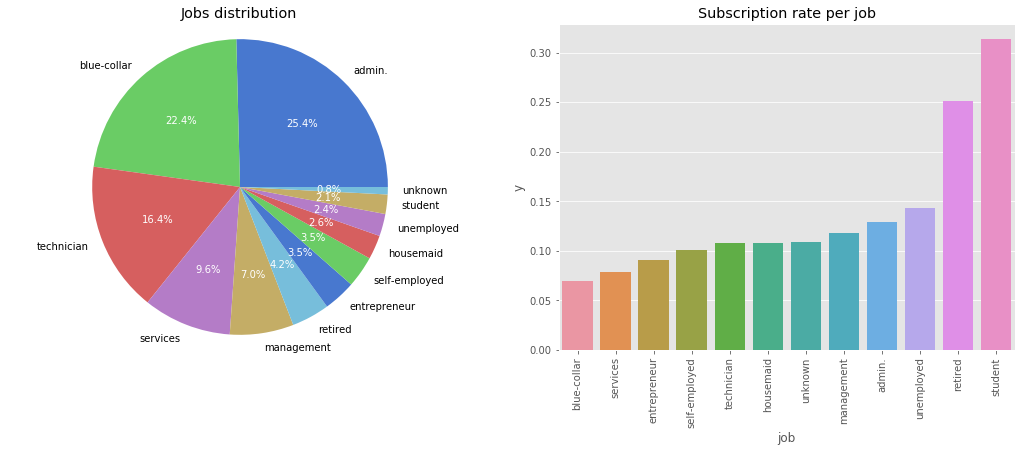

In [9]:
jobs = train_df['job'].value_counts()
labels = jobs.index.values.tolist()
data = jobs.values.tolist()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 6))

wedges, texts, autotexts = ax1.pie(data, labels = labels, autopct='%.1f%%',
                                   colors=sns.color_palette("muted", len(data)),
                                   textprops=dict(color="w"))

plt.setp(texts, color ="Black")
ax1.set_title("Jobs distribution")
ax1.axis('equal')

job_df = train_df[['job','y']].groupby(['job'], as_index=False).mean().sort_values(by='y',ascending=True)
g = sns.barplot(x="job", y="y", data=job_df, ax=ax2)
ax2.set_title("Subscription rate per job")
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

plt.show()

Only 0.8% of missing rows in the job feature.

The subscripion rate is higher among students and retired people. For retirees, this is in line with what we have seen for senior people. 

We do the same for education feature:

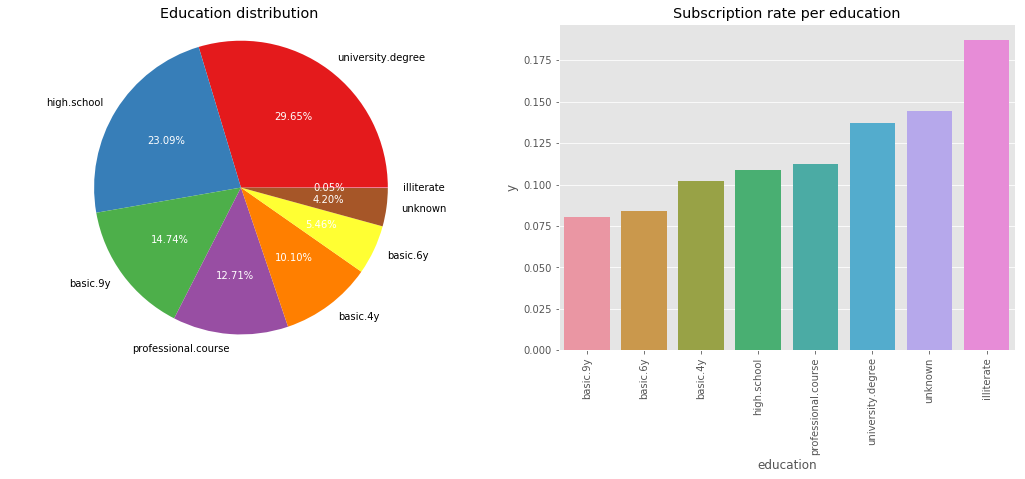

In [10]:
educations = train_df['education'].value_counts()
labels = educations.index.values.tolist()
data = educations.values.tolist()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 6))

wedges, texts, autotexts = ax1.pie(data, labels = labels, autopct='%.2f%%',
                                   colors=sns.color_palette("Set1", len(data)),
                                   textprops=dict(color="w"))

plt.setp(texts, color ="Black")
ax1.set_title("Education distribution")
ax1.axis('equal')

education_df=train_df[['education','y']].groupby(['education'], as_index=False).mean().sort_values(by='y',ascending=True)
g = sns.barplot(x="education", y="y", data=education_df, ax=ax2)
ax2.set_title("Subscription rate per education")
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

plt.show()

4.2% of missing values for this feature.

People with higher educational level are more likely to subscribe, except for illiterate people. However, there is not a significant difference in the subscription rate between all these levels, which means that this feature is not discriminative.

Now let's move on to the campaign-related features:

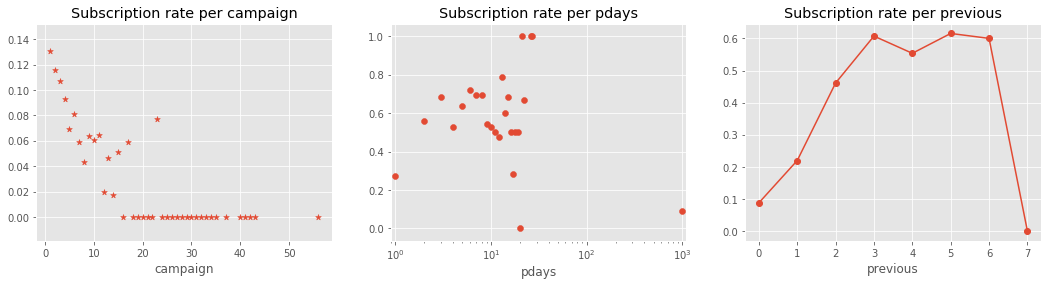

In [11]:
fig, axes = plt.subplots(ncols=3,figsize=(18,4))
columns = ['campaign','pdays']
markers = ['*','o']
for i, column in enumerate(columns):
    column_y = train_df[[column,'y']].groupby([column],as_index=False).mean()
    axes[i].scatter(column_y[column],column_y['y'],marker = markers[i])
    axes[i].set_xlabel(column)
    axes[i].set_title("Subscription rate per " + column)
    if column == 'pdays':
        axes[i].set_xscale('log')
        axes[i].set_xlim(left = 0.9, right = 1100)

previous_y = train_df[['previous','y']].groupby(['previous'], as_index=False).mean()
axes[2].plot(previous_y.previous, previous_y.y, 'o-')
axes[2].set_xlabel('previous')
axes[2].set_title("Subscription rate per previous")
plt.show()

- Sometimes, tens of contacts are made in a single campaign. This is quite huge!
- Fewer a client is contacted during a campaign, the more likely he is to subscribe.
- The subscription rate for clients who are contacted in a previous campaign is higher than average.

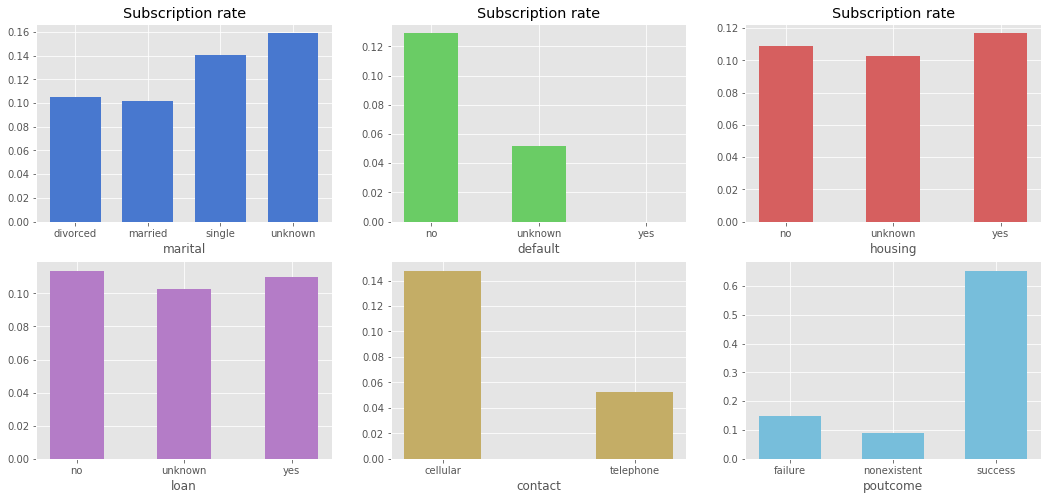

In [12]:
import itertools

fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(2,3)

columns = ['marital','default','housing','loan','contact','poutcome']
colors = sns.color_palette("muted", n_colors=len(columns))
widths = [.7,.5,.5,.5,.4,.6]
k=0
for i,j in itertools.product(range(2),range(3)):
    column_df = train_df[[columns[k],'y']].groupby([columns[k]], as_index=False).mean()
    ax = plt.subplot(gs[i,j])
    ax.bar(column_df[columns[k]], column_df['y'], color = colors[k], width = widths[k])
    ax.set_xlabel(columns[k])
    if i == 0:
        ax.set_title('Subscription rate')
    k+=1
plt.show()

These charts represent the subscription rate per each category and each feature. Here are a few findings:
- Clients with a credit in default do not subscribe.
- People who subscribed in a previous campaign are more likely to subscribe in the current campaign.
- Among all these features, default, contact and poutcome are more correlated to the target variable.

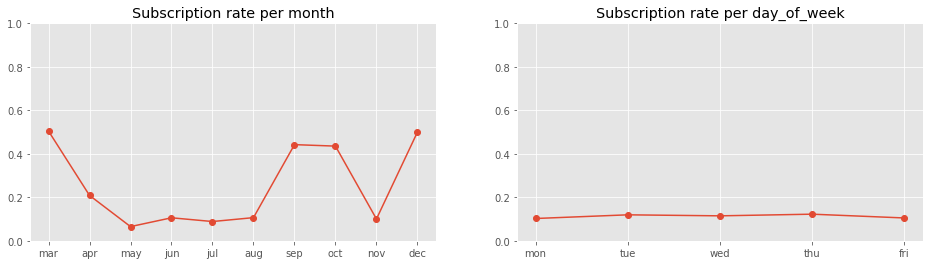

In [13]:
month_mapping = {'jan':1
                ,'feb':2
                ,'mar':3
                ,'apr':4
                ,'may':5
                ,'jun':6
                ,'jul':7
                ,'aug':8
                ,'sep':9
                ,'oct':10
                ,'nov':11
                ,'dec':12
                }

day_mapping = {'mon':1
              ,'tue':2
              ,'wed':3
              ,'thu':4
              ,'fri':5
              ,'sat':6
              ,'sun':7}

fig, axes = plt.subplots(1,2,figsize=(16,4))
axes[0].xaxis.set_major_locator(plt.MaxNLocator(10))
axes[1].xaxis.set_major_locator(plt.MaxNLocator(5))

columns = ['month','day_of_week']
for i, column in enumerate(columns):
    column_df = train_df[[column,'y']].groupby([column], as_index=False).mean() 
    column_df['day_or_month'] = column_df[column].map(month_mapping if column == 'month' else day_mapping)
    column_df = column_df.sort_values(by='day_or_month',ascending=True)#sorting by month/day
    column_df.drop('day_or_month',axis=1,inplace=True)
    column_df.reset_index(inplace=True,drop=True)
    axes[i].plot(column_df['y'].values, 'o-')
    axes[i].set_xticklabels(['']+column_df[column].values.tolist())
    axes[i].set_ylim((0,1))
    axes[i].set_title("Subscription rate per " + column)

plt.show()

The day_of_week feature has no influence over the target variable. We can reasonably rule out this feature from our dataset.

In the next part, I will show you how to prepare data for our prediction task.

## 2 - Feature engineering##
In this part, we will see how to process input variables in such a way that Machine Learning algorithms can be applied on the data.

I will also engineer new features based on the existing ones.

But before, let's deal with the missing values. Below the set of features with missing values along with occurance frequencies:


In [14]:
columns = ['job','marital','education','default','housing','loan']
train_df[columns].replace('unknown', np.NaN).isnull().sum()/train_df.shape[0]

job          0.008073
marital      0.001912
education    0.042033
default      0.207344
housing      0.023612
loan         0.023612
dtype: float64

There are many techniques to handle missing values, and each technique has its pros and cons. For example, deleting rows with missing values, replacing with mean/median/mode, regression imputation, etc. Some Machine Learning algorithms even support missing values, so you may choose not to handle them.

For the sake of simplicity, here is how I will proceed:
- For default feature, the missing value will be considered as a new category.
- For education, the missing value will be imputed with the most frequent value in this variable.
- For the remaining ones, I will delete the corresponding rows.

First, we start with the third point:

In [15]:
#replace unknown with np.nan which is more handy at imputation
train_df.replace('unknown', np.NaN, inplace = True)
test_df.replace('unknown', np.NaN, inplace = True)

drop_nan = ['housing','loan','marital','job']
train_df.dropna(axis = 0, subset = drop_nan, inplace = True) 
test_df.dropna(axis = 0, subset = drop_nan, inplace = True)

Let's check how many rows are left:

In [16]:
# number of  records in train and test sets
n_train = train_df.shape[0]
n_test = test_df.shape[0]

train_df.shape, test_df.shape

((31855, 21), (7948, 21))

We only deleted less than 3.5% of total records.

In the previous part, we made a hypothesis regarding nonexistent category in poutcome variable. Let's now further analyse this feature:

In [17]:
#consider nonexistent as non-missing value
print('If poutcome = nonexistent then pdays takes on these values:') 
print(train_df[train_df['poutcome'] == 'nonexistent'].pdays.unique())
print('*****')
print('If pdays = 999 then poutcome takes on these values:') 
print(train_df[train_df['pdays'] == 999].poutcome.unique())
print('*****')
print('# of records with both pdays = 999 and poutcome = failure')
print(train_df[(train_df['pdays'] == 999) & (train_df['poutcome'] == 'failure')].shape[0])

If poutcome = nonexistent then pdays takes on these values:
[999]
*****
If pdays = 999 then poutcome takes on these values:
['nonexistent' 'failure']
*****
# of records with both pdays = 999 and poutcome = failure
3150


poutcome = nonexistent implies that pdays = 999, the inverse is not true. There is no equivalence relation betwwen these 2 categories.

When considered as a new catgory, we can simply drop the column representing nonexistent poutcome as it doesn't provide additional information.

Now let's process/engineer input features. A rule-of-thumb when it comes to data preparation is to never use data from the test set to process input variables. Thus, the processing method will be computed using training data and then applied to both training and test sets. To make this process easier, we will combine both train and test sets:

In [18]:
def combine_data():
    # combine train and test datasets
    combined = train_df.append(test_df)
    combined.reset_index(inplace=True)
    combined.drop('index', inplace=True, axis=1)
    
    return combined

In [19]:
combined = combine_data()
combined.shape

(39803, 21)

999 is assigned by default to pdays when no contact has been made in a previous compaign. To make the most out of this attribute, I will create a new feature called is_contacted following this rule:
- if pdays = 999 then is_contacted = 0
- otherwise 1

In [20]:
#is_contacted = 0 if pdays = 999, else 1
combined['is_contacted'] = combined['pdays'].apply(lambda x:0 if x==999 else 1).astype(int)

Now let's define some functions that will be used to process input features:

In [21]:
from sklearn import preprocessing

def standardScaler(df,column):
    """
    Used to scale a variable by remving the mean and scaling to unit variance.
    This function computes the mean and std of a variable in the training dataset.
    
    Argument:
    df -- python pandas dataframe
    column -- column name
    
    Returns:
    mean and std of df's column
    """
    
    column_values = df[[column]]
    std_scaler = preprocessing.StandardScaler()
    return std_scaler.fit(column_values)

def minMaxScaler(df,column):
    """
    Used to scale a variable by remving the min and scaling to [0,1] range.
    This function computes the min and max of a variable in the training dataset.
    
    Argument:
    df -- python pandas dataframe
    column -- column name
    
    Returns:
    min and max of df's column
    """
    
    column_values = df[[column]]
    min_max_scaler = preprocessing.MinMaxScaler()
    return min_max_scaler.fit(column_values)

def create_dummies(df,column,dummy_na = False):
    """
    Converts categorical variables into dummy variables.
    Joins the resulting dummies to the initial dataframe.
    
    Argument:
    df -- python pandas dataframe
    column -- column name
    dummy_na -- whether to add an extra column for missing values
    
    Returns:
    python pandas dataframe
    """
    df_dummies = pd.get_dummies(df[[column]], prefix = column, dummy_na = dummy_na).astype(int)
    return df_dummies
  

For numerical features, we either apply standardScaler or minMaxScaler functions. For education variable, we impute missing values using mode (most frequent) strategy:

In [22]:
##preprocess variables
##use the train set combined.iloc[:n_train] to compute the processing rule

#Standard scaling
columns_ss = ['age','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
for column in columns_ss:
   scaler = standardScaler(combined.iloc[:n_train],column)
   combined[[column]] = scaler.transform(combined[[column]])

#MinMax scaling
columns_mm = ['campaign','previous']
for column in columns_mm:
    scaler = minMaxScaler(combined.iloc[:n_train],column)
    combined[[column]] = scaler.transform(combined[[column]])
    
#imputation
combined['education'].replace(np.nan,combined.iloc[:n_train]['education'].value_counts().index[0],inplace=True)

combined.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_contacted
0,0.006694,services,divorced,high.school,no,yes,no,telephone,apr,fri,...,999,0.000000,nonexistent,-1.196772,-0.863007,-1.420484,-1.276850,-0.939682,0,0
1,-0.665355,unemployed,married,university.degree,no,yes,no,cellular,aug,fri,...,999,0.000000,nonexistent,0.839715,-0.224746,0.955939,0.774437,0.844023,0,0
2,-0.857369,admin.,divorced,professional.course,no,yes,no,cellular,mar,tue,...,999,0.142857,failure,-1.196772,-0.354474,1.236789,-1.709246,-2.189659,1,0
3,-1.049383,blue-collar,single,basic.9y,no,yes,no,telephone,jun,fri,...,999,0.000000,nonexistent,0.839715,1.541280,-0.275480,0.765213,0.844023,0,0
4,-1.049383,unemployed,single,high.school,no,yes,no,cellular,oct,fri,...,999,0.000000,nonexistent,-0.751290,1.776520,-1.938976,-1.493625,-2.813265,0,0


Now, it is time to convert binary variables into (0,1) range. We also group basic educational levels in a single category in order to reduce the number of features:

In [23]:
#Transform binary features into 1/0
columns_yn = ['housing','loan']
for column in columns_yn:
    combined[[column]] = combined[column].map(lambda x: 1 if x == 'yes' else 0).astype(int)

#idem for contact variable
combined[['contact']] = combined['contact'].map(lambda x: 1 if x == 'cellular' else 0).astype(int)

#replace all basic educational levels with 'basic'
combined['education'].replace(r'basic.[0-9a-zA-Z]*','basic',inplace = True,regex = True)

combined.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_contacted
0,0.006694,services,divorced,high.school,no,1,0,0,apr,fri,...,999,0.000000,nonexistent,-1.196772,-0.863007,-1.420484,-1.276850,-0.939682,0,0
1,-0.665355,unemployed,married,university.degree,no,1,0,1,aug,fri,...,999,0.000000,nonexistent,0.839715,-0.224746,0.955939,0.774437,0.844023,0,0
2,-0.857369,admin.,divorced,professional.course,no,1,0,1,mar,tue,...,999,0.142857,failure,-1.196772,-0.354474,1.236789,-1.709246,-2.189659,1,0
3,-1.049383,blue-collar,single,basic,no,1,0,0,jun,fri,...,999,0.000000,nonexistent,0.839715,1.541280,-0.275480,0.765213,0.844023,0,0
4,-1.049383,unemployed,single,high.school,no,1,0,1,oct,fri,...,999,0.000000,nonexistent,-0.751290,1.776520,-1.938976,-1.493625,-2.813265,0,0


Finally, we transform categorical features using dummy encoding:

In [24]:
##Create dummy variables out of categorical variables

#This function is used to create a new category for the missing values in the default variable
dummy_na = lambda x: True if x == 'default' else False

columns_dm = ['job','marital','education','default','poutcome','month']
for column in columns_dm:
    dummy_nan = dummy_na(column)
    df_dummies = create_dummies(combined,column,dummy_na = dummy_nan)
    combined = pd.concat([combined, df_dummies], axis = 1)
    
combined.shape

(39803, 57)

We should drop the columns we no longer need:

In [25]:
#drop columns
drop_elements = ['duration','pdays','month','day_of_week','job','marital','education','default','poutcome']
combined.drop(drop_elements, axis = 1, inplace = True)

combined.shape

(39803, 48)

We end up with 47 input features + 1 target variable. This is quite large.

Next, we will see how we can reduce this number of features.

Below, we plot the matrix of correlations of features using Pearson measurement (double-click to zoom-in):

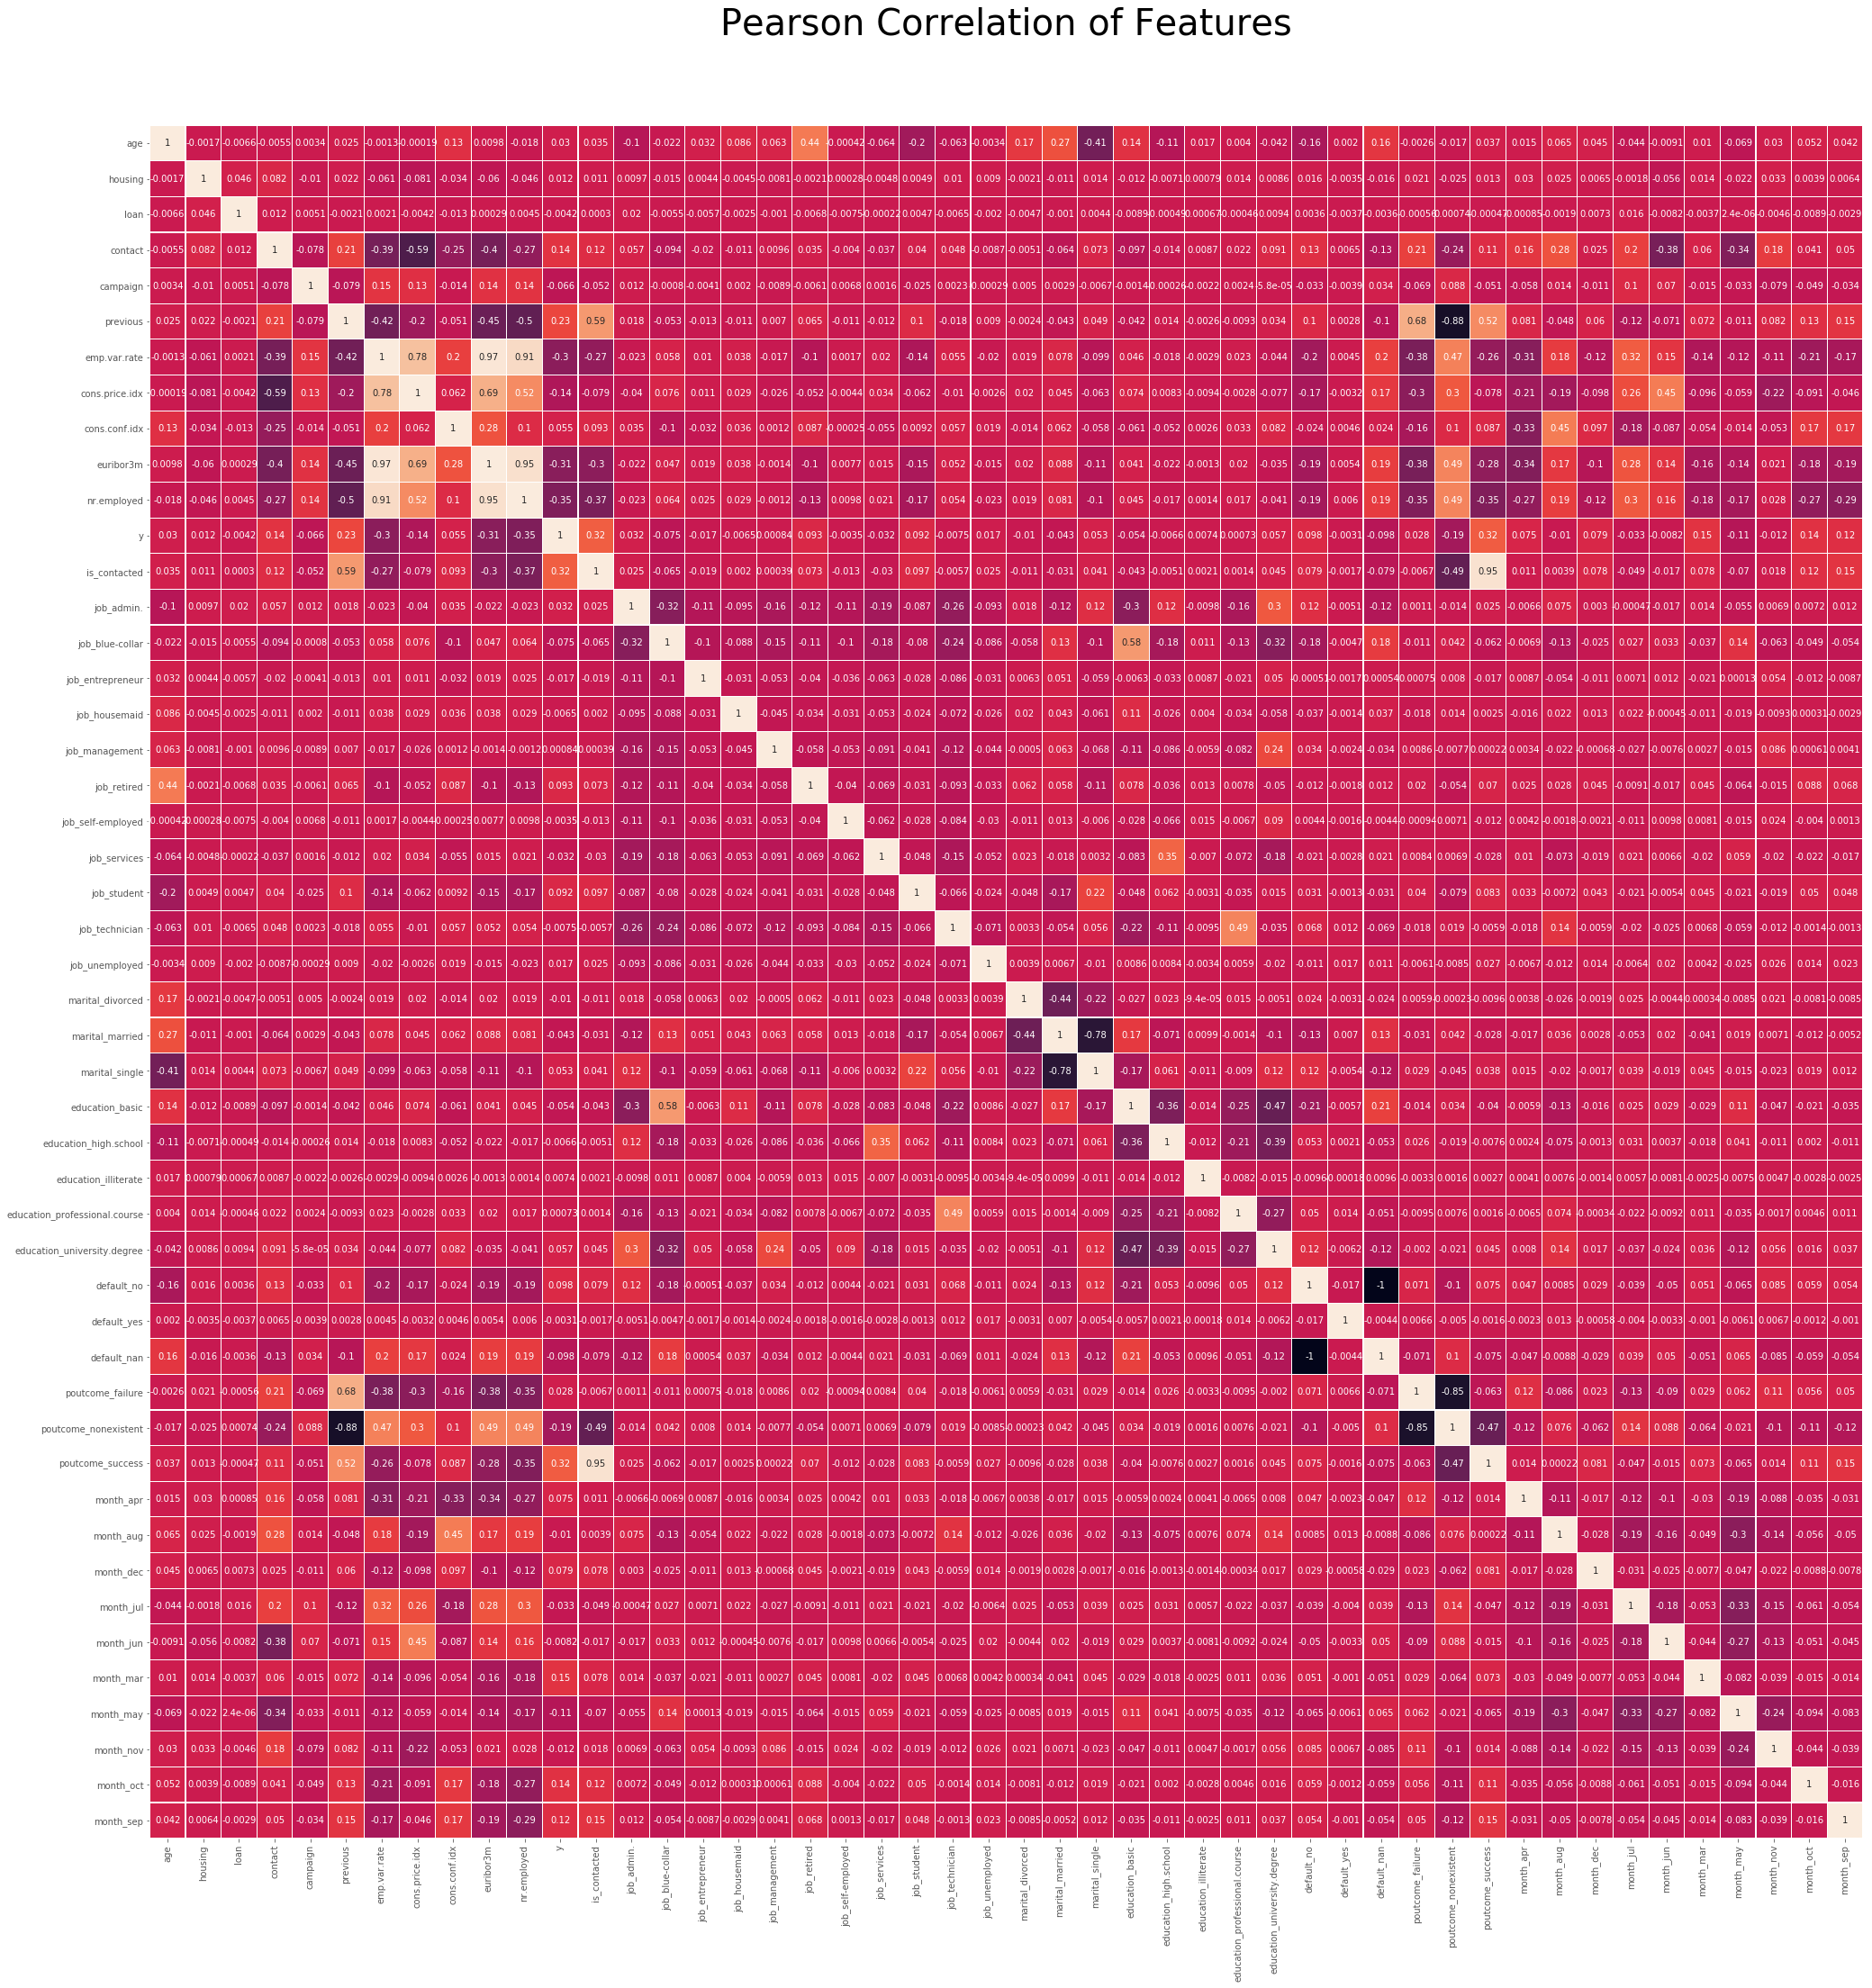

In [26]:
plt.figure(figsize=(35,35))
plt.title('Pearson Correlation of Features', y=1.05, size=40)
sns.heatmap(combined.astype(float).corr(),linewidths=0.1,vmax=1.0, \
            square=True, linecolor='white', annot=True, cbar = False)
plt.show()

We can safely discard features that are strongly correlated with each other by keeping only one in each pair of these variables. Here we target the correlation coefficients > 0.9 in absolute value:

In [27]:
combined.drop(['default_nan','poutcome_success','emp.var.rate','euribor3m',], axis = 1, inplace = True)
combined.shape

(39803, 44)

43 input features. Still much to do to reduce this number

## 3 - Classification##
In this part, I will build statistical models to predict the target variable using the features we have engineered so far.

There are a wide variety of models to use for this task. Here, I will mainly use Random Forests. Also, I will present some re-sampling techniques used to balance classes. We will see how these techniques combine with Random Forests and compare their performances. To do this, we are going to go through these steps:

1. Recover the train and test sets from the combined dataset
2. Apply Feature selection to reduce data dimensionality.
3. Build predictive models over the train set.
4. Use the models to make predictions on the test set.
5. Evaluate the models using a set of appropriate metrics and compare results.

Before starting, let's import the useful packages:

In [28]:
warnings.filterwarnings('ignore', category = DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

We now create a function to recover train and test sets:

In [29]:
def recover_dataset():
    global combined
    
    train = combined.iloc[:n_train]
    test = combined.iloc[n_train:]
    
    return train, test

In [30]:
train, test = recover_dataset()
train.shape, test.shape

((31855, 44), (7948, 44))

Also, separate the predictive and target variables:

In [31]:
#get input features and target variable
X_train = train.drop(['y'], axis = 1, inplace = False)
y_train = train['y']
X_test = test.drop(['y'], axis = 1, inplace = False)
y_test = test['y']
X_train.shape, X_test.shape

((31855, 43), (7948, 43))

**Feature selection**

So far, we've come up with 43 features. We need to reduce this number. Here is where Feature selection comes in.

Feature selection is a technique used to reduce data dimensionality. It has many benefits:
- Reduce overfitting and help the model generalize better.
- Decrease redundancy among data.
- Speed-up the learning process.

There are many ways to perform feature selection, I choose to use Random Forests for this task. First, It computes features' importances and then discards the less relevant ones:

In [32]:
SEED = 0 #for reproducibility
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state = SEED)
clf = clf.fit(X_train, y_train)

To compute features' importance, we do this: 

In [33]:
features = pd.DataFrame({'feature':X_train.columns,'importance':clf.feature_importances_})
features.sort_values(by=['importance'],ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.head()

,importance
feature,
default_yes,8.577274e-07
education_illiterate,2.725948e-04
month_dec,1.680813e-03
month_nov,3.284322e-03
month_aug,3.502539e-03


Let's take a look at the graph:

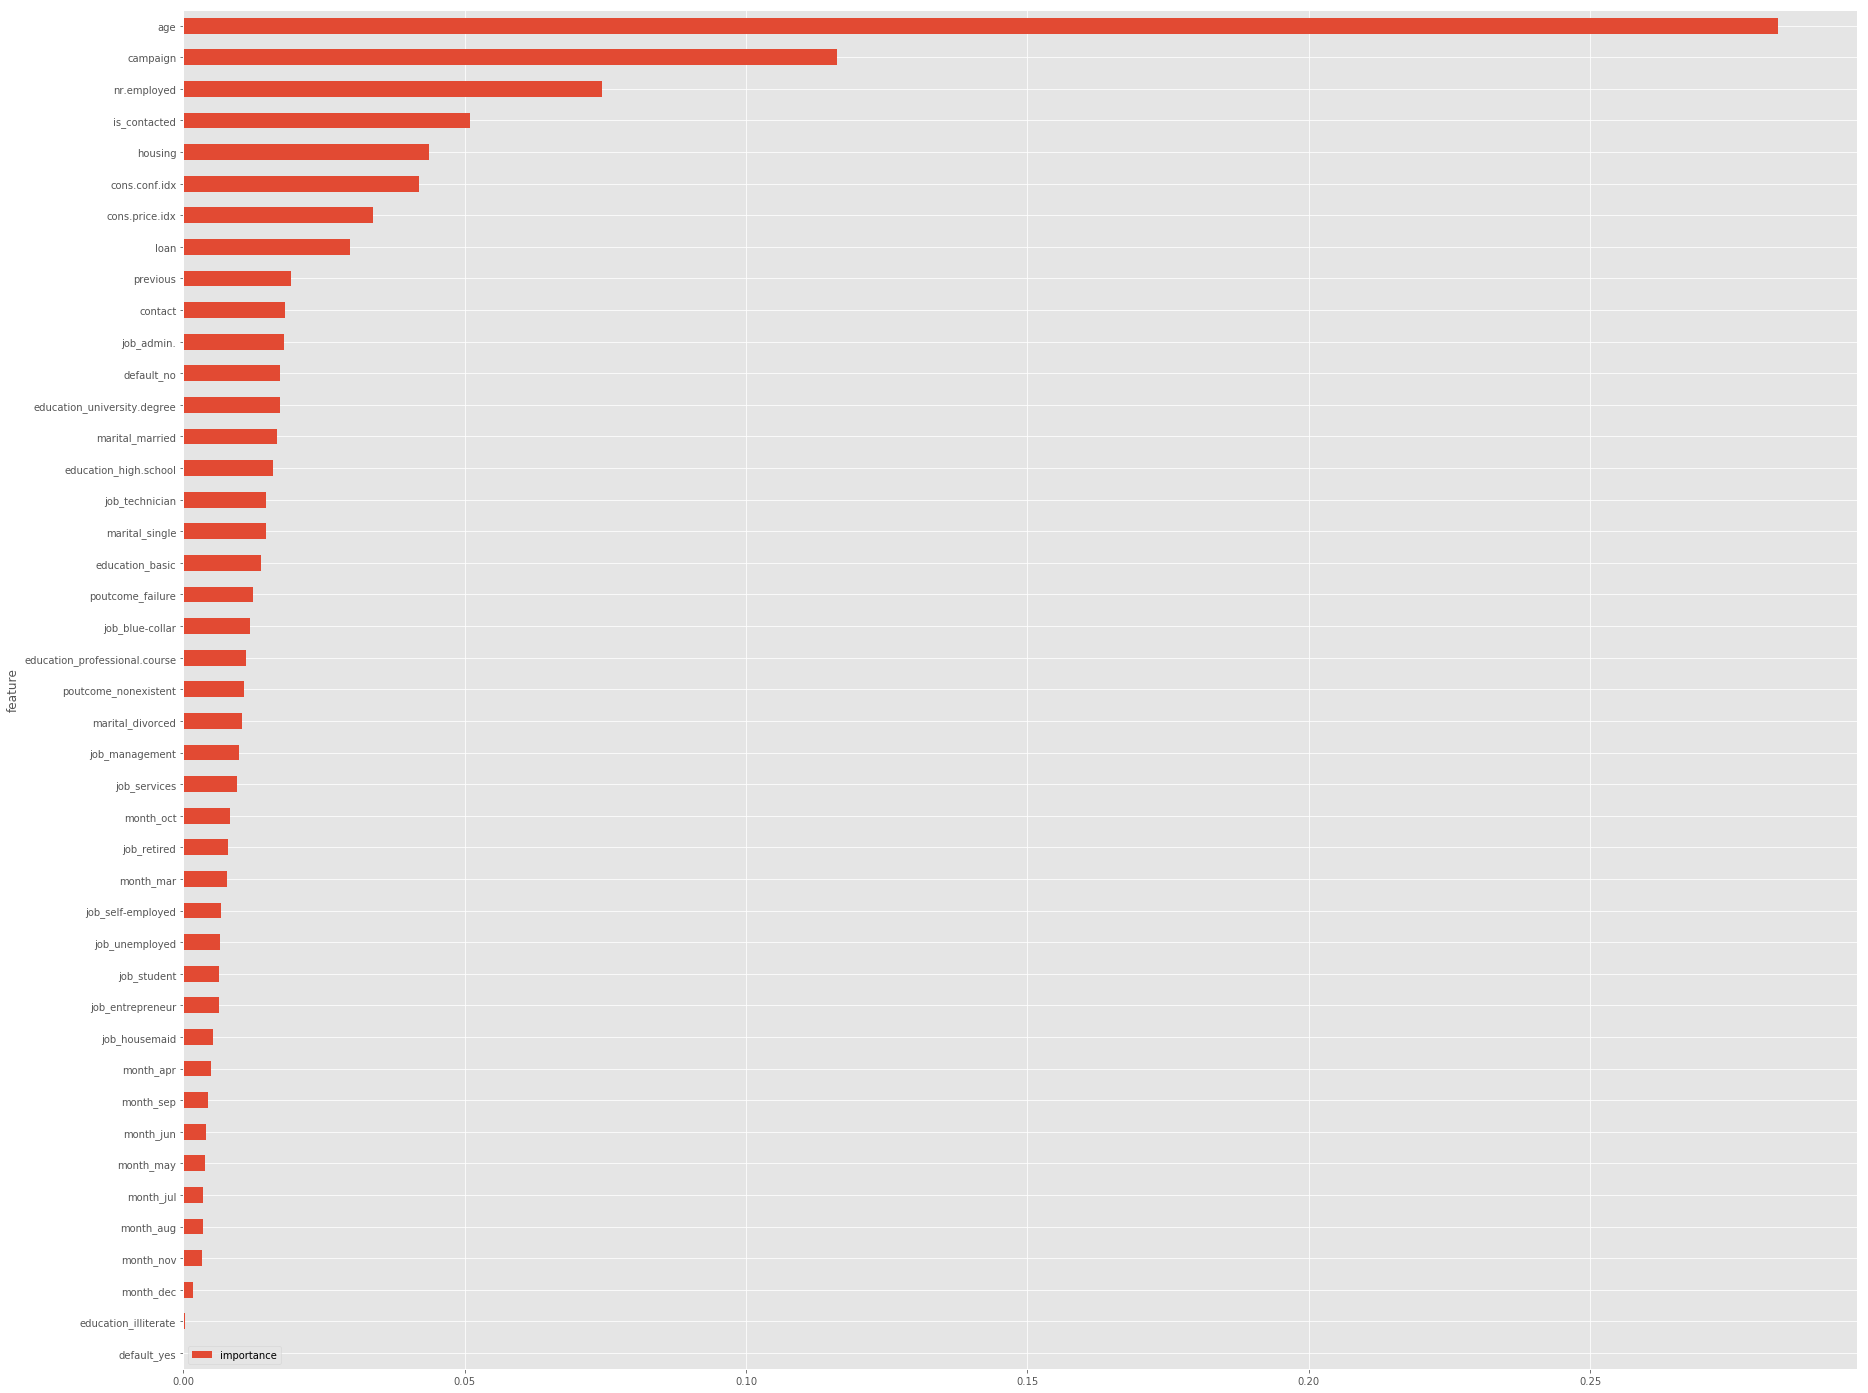

In [34]:
features.plot(kind='barh', figsize=(30, 25))
plt.show()

As you may notice, features like age, campaign and is_contacted come at the top of the list.

Surprisingly, some social and economic indicators have great importance too!

Following this, we transform the train and test sets to get reduced versions:

In [35]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(X_train)
train_reduced.shape

(31855, 8)

In [36]:
test_reduced = model.transform(X_test)
test_reduced.shape

(7948, 8)

Perfect, we now have only 8 input features to play with!

**Modeling**

In this section, I will build classification models, train them and make predictions.

To evaluate these models, I use 4 metrics: accuracy, precision, recall and Roc area under curve (roc_auc). In addition, I wil print the confusion matrices and ROC curves.

Below, a function used to print the confusion matrix:

In [37]:
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, 
                          fig, ax,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    
    Argument:
    cm -- confusion matrix
    fig -- figure (first object of plt.subplots())
    ax -- axis (second object of plt.subplots())
    title -- title of the plot
    cmap -- colors palette
    """
    normed_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.grid(False)
    matshow = ax.matshow(cm, cmap=cmap)
    ax.set_title(title)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        cell_text = format(cm[i, j], 'd') + "\n" + '(' + format(normed_cm[i, j]*100, '.2f') + '%)'
        ax.text(j, i, cell_text,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(matshow, cax=cax)

Now, let's see how Random Forests performs on the train and test sets. 

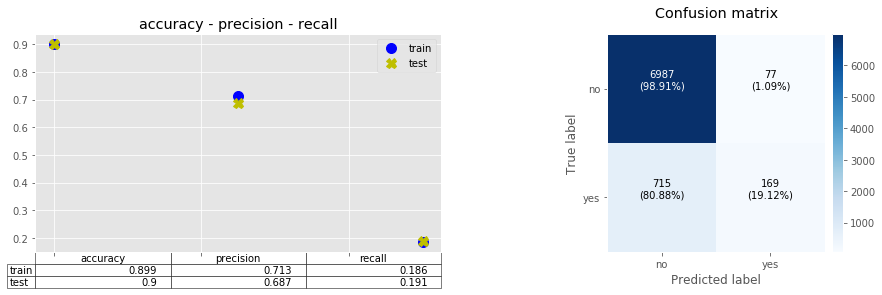

In [38]:
import pandas.tools.plotting as plotting

#Rndom Forests parameters
rf_params = {'n_estimators':50,'max_depth':4,'min_samples_split':10,\
             'min_samples_leaf':1,'max_features':'sqrt','random_state':0}

#initiation
rf = RandomForestClassifier(**rf_params)
#training
rf.fit(train_reduced,y_train)
#predicting
train_predict = rf.predict(train_reduced)
test_predict = rf.predict(test_reduced)

scoring_metrics = {'accuracy':accuracy_score
                   ,'precision':precision_score
                   ,'recall':recall_score}

#Define this dataframe to store scores of train and test sets
metrics = pd.DataFrame()
for name, metric in scoring_metrics.items():
    metrics[name] = [metric(y_train,train_predict), metric(y_test,test_predict)]

metrics.index = ['train','test']
metrics = metrics.T
 
conf_matrix = confusion_matrix(y_test,test_predict)

figsize = (16,4)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.set_xticklabels([])
ax1.set_title('accuracy - precision - recall')
ax1.plot(metrics['train'].values,'bo',markersize = 10.,label='train')
ax1.plot(metrics['test'].values,'yX',markersize = 10.,label='test')
ax1.legend()
plotting.table(ax1, np.round(metrics.T,3),loc='lower')

plot_confusion_matrix(conf_matrix,  
                      fig, ax2,
                      classes=['','no','yes'],
                      title='Confusion matrix')
plt.show()

First of all, the model performs well on both train and test sets in terms of accuracy. The model seems to generalize well.

The model achieves a 90% accuracy. However, with roughly 89% of rows belonging to the negative class, we can achieve a similar accuracy by predicting only no subscription, which is terrible! This metric is therfore not suitable for our case-study. It is preferable to focus on other metrics like precision, recall, etc.

When examining the confusion matrix, we see that the model fails to correctly label the positive class in ~81% of the time. Clearly, the model is biased toward the over-represented negative class. As result, the recall metric is very low.

Next, I will introduce some re-sampling techniques that will be used to reduce the bias induced by classes' imbalance:
- Under-sampling: under_sample from the majority class
- Over-sampling: create samples using minority cass
- A combination of the 2 previous techniques

For this, I will use Tomek link, SMOTE and a mixture of them then feed the generated dataset to Random Forests. In addition, Gradient Boosting Trees will also be used.

Here we define some useful functions:

In [39]:
def resample(X_train,y_train,sampling_method):
    """
    This function resamples train and test sets using sampling method.
    If no sampling method is provided, then it simply returns the original datasets.
    
    Argument:
    X_train -- python pandas dataframe
    y_train -- python pandas dataframe
    sampling_method -- an instance from imblearn package
    
    Returns:
    resampled train and test sets
    """
    try:
        X_resampled, y_resampled = sampling_method.fit_sample(X_train, y_train)
    except:
        X_resampled, y_resampled = X_train,y_train
    return X_resampled, y_resampled

def predict(clf,clf_params,X_train,y_train,X_test,sampling_method=None):
    """
    This function is used to build a classification model on train sets and make prediction on test set.
    
    Argument:
    clf -- sklearn estimator
    clf_params -- a dictionary of parameters to be passed to the estimator
    X_train -- input features in the train set
    y_train -- target variable in the train set
    X_test -- input features in the test set 
    sampling_method -- an instance from imblearn package
    
    Returns:
    predictions -- prediction dataframe
    proba_predictions -- a datframe of probabilities
    """
    train, target = resample(X_train,y_train,sampling_method)
    classifier= clf(**clf_params)
    classifier.fit(train,target)
    predictions = classifier.predict(X_test)
    proba_predictions = classifier.predict_proba(X_test)[:,1]

    return predictions, proba_predictions

Before delving into the models, here are the parameters to be passed to the models:

In [40]:
# RandomForest parameters
rf_params = {'n_estimators':50,'max_depth':4,'min_samples_split':10,\
             'min_samples_leaf':1,'max_features':'sqrt','random_state':0}

# balanced RandomForest parameters
brf_params = {'n_estimators':50,'max_depth':4,'min_samples_split':10,\
             'min_samples_leaf':1,'max_features':'sqrt','random_state':0,'class_weight':'balanced'}

# Gradient Boosting parameters
gb_params = {'n_estimators': 10,'max_depth': 4,'min_samples_split':2,'learning_rate':0.3,\
             'min_samples_leaf': 3,'max_features':'log2','random_state':0}

It is time to see how resampling techniques perform on unbalanced datatsets. All the metrics here are computed on the test set:

In [41]:
#Initiate re-sampling algorithms
tomek = TomekLinks(random_state = SEED)
smote = SMOTE(random_state = SEED)
smoteTomek = SMOTETomek(random_state = SEED)

#Usefum when iterating on classifiers
sampling_methods = [None,tomek,smote,smoteTomek,None,None]
classifiers = {'RF':[RandomForestClassifier,rf_params]
              ,'RF + TOMEK':[RandomForestClassifier,rf_params]
              ,'RF + SMOTE':[RandomForestClassifier,rf_params]
              ,'RF + SMOTE + TOMEK':[RandomForestClassifier,rf_params]
              ,'Balanced RF':[RandomForestClassifier,brf_params]
              ,'GB':[GradientBoostingClassifier,gb_params]}
scoring_metrics = [accuracy_score,precision_score,recall_score,roc_auc_score]

predictions = pd.DataFrame()#To store predictions
proba_predictions = pd.DataFrame()#to plot ROC curve
performance_metrics = pd.DataFrame()#to store scores

for sampling_method, (estimator, (clf,clf_params)) in zip(sampling_methods,classifiers.items()):
    
    predictions[estimator],proba_predictions[estimator] = predict(clf,clf_params,
                                                                  train_reduced,y_train,test_reduced,
                                                                  sampling_method)
    scores = []#list of scores for a classifier
    for scoring in scoring_metrics:
        scores.append(scoring(y_test,predictions[estimator]))
    performance_metrics[estimator] = scores

performance_metrics.index = ['accuracy','precision','recall','roc_auc']
performance_metrics = performance_metrics.T
performance_metrics

,accuracy,precision,recall,roc_auc
RF,0.900352,0.686992,0.191176,0.590138
RF + TOMEK,0.900226,0.684211,0.191176,0.590067
RF + SMOTE,0.843483,0.371977,0.591629,0.733314
RF + SMOTE + TOMEK,0.843231,0.371449,0.591629,0.733173
Balanced RF,0.834046,0.355482,0.605204,0.733944
GB,0.899975,0.657244,0.210407,0.598338


To get a visual plot of these performances, we run the cell below:

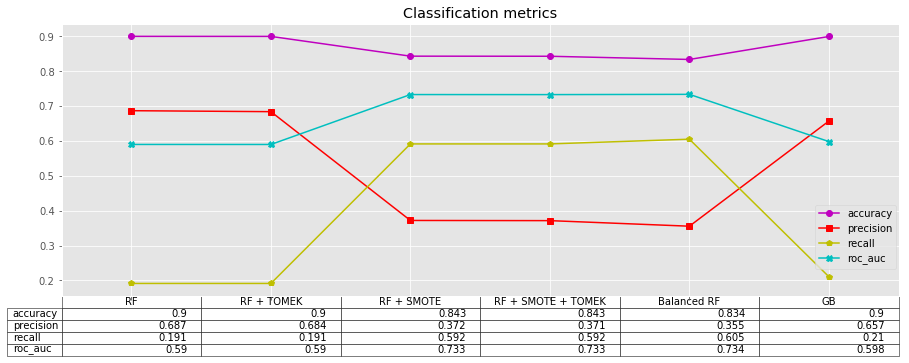

In [42]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_xmargin(.1)
ax.set_xticklabels([])
ax.set_title('Classification metrics')
ax.plot(performance_metrics['accuracy'].values,'mo-',label='accuracy')
ax.plot(performance_metrics['precision'].values,'rs-',label='precision')
ax.plot(performance_metrics['recall'].values,'yp-',label='recall')
ax.plot(performance_metrics['roc_auc'].values, 'cX-',label='roc_auc')
ax.legend(loc=(.9,.1))
plotting.table(ax, np.round(performance_metrics.T,3),loc='lower')
plt.show()

We can draw our first conclusions:
- Random Forests and Gradient Boosting Trees have nearly identical performances on this dataset.
- Tomek link under-sampling method have no influence on performances whether is is applied solely or in combination with over-sampling methods.
- However, when using SMOTE, there is substantial gain in recall score. This comes at the price of a lower accuracy and precision. If we want to put effort on labeling correctly the positive class, then the negative class is penalized. So always it is a matter of trade-off.
- Interestingly, balanced Random Forests are as good as Random Forests combined with SMOTE. Especially, they both have the highest roc auc which can be chosen as model selection criterion.

We finish by ploting roc curves:

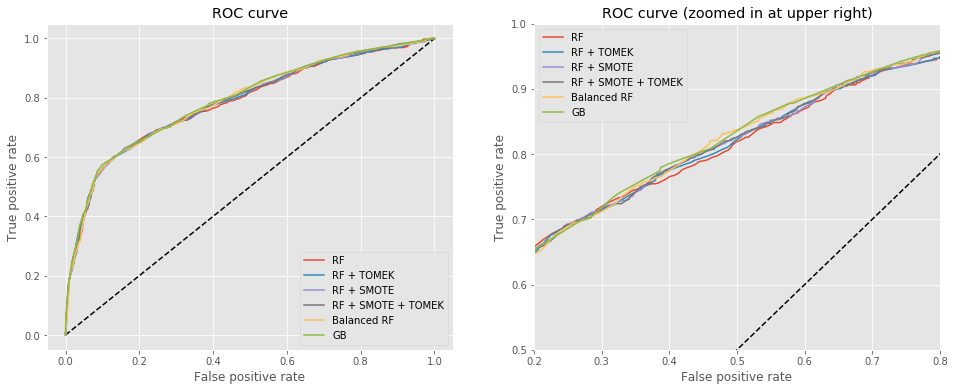

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve')

ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlim((.2,.8))
ax2.set_ylim((.5,1))
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title('ROC curve (zoomed in at upper right)')

for estimator,_ in classifiers.items():
    fpr, tpr, _ = roc_curve(y_test, proba_predictions[estimator])
    ax1.plot(fpr, tpr,label=estimator)
    ax2.plot(fpr, tpr,label=estimator)
ax1.legend(loc='lower right')
ax2.legend(loc='upper left')
plt.show()

## 4 - Conclusion##
In this article, we have explored a interesting dataset related to bank marketing and hosted by UCI Machine Learning repository.

In this end-to-end project, we covered:
- Data exploration and visualization
- Data preparation: data cleaning, feature engineering
- Feature selection
- Binary classification
- Evaluation and comparaison between different models

There are still many things to try out at each level of this pipeline to improve my solution, for example:
- Explore more input features and try to spot hidden correlations.
- Use more clever imputation techniques.
- Try out different resampling techniques.
- Try different models: Logisitc Regression, SVC, XGBoost, Neural Networks, etc and train them on both the original and the modified datasets.
- Hyperparametrs tuning to find the parameters that best fit the dataset.
- etc,

Thank you for taking the time to read my article, hopefully you have enjoyed it!